5001it [00:00, 12531.49it/s]
101it [00:00, 6002.31it/s]
21it [00:00, 20536.35it/s]


Epoch: 01 | Time: 0m 15s
	Train Loss: 7.670 | Train PPL: 2143.559
	 Val. Loss: 6.917 |  Val. PPL: 1009.570
Epoch: 02 | Time: 0m 15s
	Train Loss: 6.629 | Train PPL: 757.058
	 Val. Loss: 6.489 |  Val. PPL: 657.924
Epoch: 03 | Time: 0m 15s
	Train Loss: 6.255 | Train PPL: 520.729
	 Val. Loss: 6.062 |  Val. PPL: 429.416
Epoch: 04 | Time: 0m 15s
	Train Loss: 5.813 | Train PPL: 334.666
	 Val. Loss: 5.685 |  Val. PPL: 294.465
Epoch: 05 | Time: 0m 15s
	Train Loss: 5.436 | Train PPL: 229.450
	 Val. Loss: 5.407 |  Val. PPL: 223.024
Epoch: 06 | Time: 0m 15s
	Train Loss: 5.138 | Train PPL: 170.415
	 Val. Loss: 5.209 |  Val. PPL: 182.849
Epoch: 07 | Time: 0m 15s
	Train Loss: 4.898 | Train PPL: 134.034
	 Val. Loss: 5.062 |  Val. PPL: 157.903
Epoch: 08 | Time: 0m 15s
	Train Loss: 4.693 | Train PPL: 109.174
	 Val. Loss: 4.951 |  Val. PPL: 141.354
Epoch: 09 | Time: 0m 15s
	Train Loss: 4.510 | Train PPL:  90.912
	 Val. Loss: 4.858 |  Val. PPL: 128.731
Epoch: 10 | Time: 0m 15s
	Train Loss: 4.345 | Train P

<Figure size 432x288 with 0 Axes>

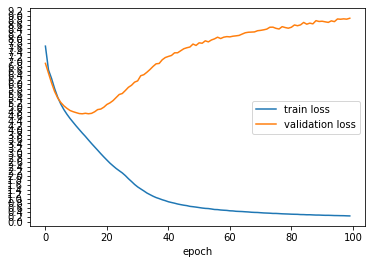

In [1]:
"""
# Bug Fixing Reference:
* TorchText usage example and complete code: https://www.programmersought.com/article/7283735573/
* https://colab.research.google.com/github/bentrevett/pytorch-sentiment-analysis/blob/master/A%20-%20Using%20TorchText%20with%20Your%20Own%20Datasets.ipynb#scrollTo=9vXi5qGV9v7h
* https://wangjiosw.github.io/2020/02/29/deep-learning/torchtext_use/
* https://github.com/pytorch/text/issues/664
* https://github.com/pytorch/text/issues/474
* https://stackoverflow.com/questions/56010551/pytorch-embedding-index-out-of-range
* https://discuss.pytorch.org/t/embeddings-index-out-of-range-error/12582
* https://www.programmersought.com/article/97387644893/

# Documentations:
* TORCHTEXT.DATASETS: https://pytorch.org/text/stable/datasets.html#multi30k
* SOURCE CODE FOR TORCHTEXT.DATA.FIEL: https://pytorch.org/text/_modules/torchtext/data/field.html
* Embedding Error Index out of Range in self: https://discuss.pytorch.org/t/embedding-error-index-out-of-range-in-self/81550

# Other Reference:
* https://github.com/pytorch/text/issues/652
"""

import codecs
import os
import math, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import einops
import gdown
import spacy
import random, math, time
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator, Dataset, Example
from einops import rearrange
from tqdm import tqdm

# 為了重複實驗方便，我們固定隨機種子
SEED = 87

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

''' Data Source Configuration '''
TRAIN_DATA_X_PATH = "C:\\Users\\User\\Desktop\\Ricardo\\KnowledgeGraph_materials\\data_kg\\CLTS\\train.src"
TRAIN_DATA_y_PATH = "C:\\Users\\User\\Desktop\\Ricardo\\KnowledgeGraph_materials\\data_kg\\CLTS\\train.tgt"
VALID_DATA_X_PATH = "C:\\Users\\User\\Desktop\\Ricardo\\KnowledgeGraph_materials\\data_kg\\CLTS\\valid.src"
VALID_DATA_y_PATH = "C:\\Users\\User\\Desktop\\Ricardo\\KnowledgeGraph_materials\\data_kg\\CLTS\\valid.tgt"
TEST_DATA_X_PATH = "C:\\Users\\User\\Desktop\\Ricardo\\KnowledgeGraph_materials\\data_kg\\CLTS\\test.src"
TEST_DATA_y_PATH = "C:\\Users\\User\\Desktop\\Ricardo\\KnowledgeGraph_materials\\data_kg\\CLTS\\test.tgt"


''' Data Configuration '''
TRAIN_SAMPLE_NUM = 5000
VALID_SAMPLE_NUM = 100
TEST_SAMPLE_NUM = 20
WORD_MIN_FREQUENCY = 0
# MAX_LENGTH_INPUT = int(np.max([len(data)+2 for data in train_x_list]))
# MAX_LENGTH_OUTPUT = int(np.max([len(data)+2 for data in train_y_list]))
MAX_LENGTH = 500
BOS_TOKEN = "<bos>"
EOS_TOKEN = "<eos>"

''' Model Parameters '''
D_MODEL = 512
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
N_EPOCHS = 100
CLIP = 1
BATCH_SIZE = 32

# 資料前處理

def tokenize(text):
    return [char for char in text.split(" ")]

## b. 添加`<BOS>`(begin of sequence),`<EOS>`(end of sequence) 在句子頭尾
# 我們利用 torchtext 中的 [Field](https://torchtext.readthedocs.io/en/latest/data.html#fields) 物件來統一處理如何將斷詞後的文本轉為 torch tensors。


''' Process Begins '''
train_x_list = []
train_y_list = []
valid_x_list = []
valid_y_list = []
test_x_list = []
test_y_list = []

file_train_x = codecs.open(TRAIN_DATA_X_PATH, mode="r", encoding="utf8")
file_train_y = codecs.open(TRAIN_DATA_y_PATH, mode="r", encoding="utf8")
file_valid_x = codecs.open(VALID_DATA_X_PATH, mode="r", encoding="utf8")
file_valid_y = codecs.open(VALID_DATA_y_PATH, mode="r", encoding="utf8")
file_test_x = codecs.open(TEST_DATA_X_PATH, mode="r", encoding="utf8")
file_test_y = codecs.open(TEST_DATA_y_PATH, mode="r", encoding="utf8")

# create list for training, validation, testing set
temp_index = 0
while True or temp_index == TRAIN_SAMPLE_NUM:
    line = file_train_x.readline()
    train_x_list.append(line.replace("\n", ""))

    if not line or temp_index == TRAIN_SAMPLE_NUM:
        temp_index = 0
        break
    else:
        temp_index += 1

while True or temp_index == TRAIN_SAMPLE_NUM:
    line = file_train_y.readline()
    train_y_list.append(line.replace("\n", ""))

    if not line or temp_index == TRAIN_SAMPLE_NUM:
        temp_index = 0
        break
    else:
        temp_index += 1

while True or temp_index == VALID_SAMPLE_NUM:
    line = file_valid_x.readline()
    valid_x_list.append(line.replace("\n", ""))

    if not line or temp_index == VALID_SAMPLE_NUM:
        temp_index = 0
        break
    else:
        temp_index += 1

while True or temp_index == VALID_SAMPLE_NUM:
    line = file_valid_y.readline()
    valid_y_list.append(line.replace("\n", ""))

    if not line or temp_index == VALID_SAMPLE_NUM:
        temp_index = 0
        break
    else:
        temp_index += 1

while True or temp_index == TEST_SAMPLE_NUM:
    line = file_test_x.readline()
    test_x_list.append(line.replace("\n", ""))

    if not line or temp_index == TEST_SAMPLE_NUM:
        temp_index = 0
        break
    else:
        temp_index += 1

while True or temp_index == TEST_SAMPLE_NUM:
    line = file_test_y.readline()
    test_y_list.append(line.replace("\n", ""))

    if not line or temp_index == TEST_SAMPLE_NUM:
        temp_index = 0
        break
    else:
        temp_index += 1
        
# convert samples to desired length
for listItem in [train_x_list, train_y_list, valid_x_list, valid_y_list, test_x_list, test_y_list]:
    for textIndex, textElement in enumerate(listItem):
        listItem[textIndex] = textElement[:MAX_LENGTH]
        

# print(len(train_x_list), len(train_y_list), len(valid_x_list), len(valid_y_list), len(test_x_list),
#           len(test_y_list))
# print(train_x_list[:2], "\n\n", train_y_list[0:2])


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SRC = Field(sequential=True,
                  tokenize=tokenize,
                  init_token = '<bos>', 
                  eos_token = '<eos>',
                  lower=True,
                  batch_first = True) 

TRG = Field(sequential=True,
                  tokenize=tokenize,
                  init_token = '<bos>', 
                  eos_token = '<eos>',
                  lower=True,
                  batch_first = True) 

def get_dataset(input_list, output_list, text_field, label_field, test=False):
	# idData pair training is useless during training, use None to specify its corresponding field
    fields = [("id", None), # we won't be needing the id, so we pass in None as the field
                 ("src", text_field), ("trg", label_field)]       
    examples = []
            
    for text, label in tqdm(zip(input_list, output_list)):
            examples.append(Example.fromlist([None, text, label], fields))
    
    return examples, fields

# Get the examples and fields needed to build the Dataset
train_examples, train_fields = get_dataset(train_x_list, train_y_list, SRC, TRG)
valid_examples, valid_fields = get_dataset(valid_x_list, valid_y_list, SRC, TRG)
test_examples, test_fields = get_dataset(test_x_list, test_y_list, SRC, TRG, test=True)

#Build Dataset dataset
train_data = Dataset(train_examples, train_fields)
valid_data = Dataset(valid_examples, valid_fields)
test_data = Dataset(test_examples, test_fields)


# print(train_data)
# print(f"Number of training examples: {len(train_data.examples)}")
# print(f"Number of validation examples: {len(valid_data.examples)}")
# print(f"Number of testing examples: {len(test_data.examples)}")

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

# print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
# print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

# print(train_data[1].src)

# Use BucketIterator instead of the usual one to automatically deal with padding problem
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), 
                                                                      batch_size = BATCH_SIZE, 
                                                                      device = device, # If you use gpu, here -1 is replaced with the GPU number.
        sort_key=lambda x: len(x.src), # the BucketIterator needs to be told what function it should use to group the data.
        sort_within_batch=False,
        repeat=False # we pass repeat=False because we want to wrap this Iterator layer.)
                                                                     )



# 建立 transformer 模型

# `Transformer` 分為編碼器 (Encoder) 與解碼器 (Decoder)，中間會有一條線 (矩陣) 連接，在 `Transformer` 中，最核心的架構為 `Multi-head Attention` 這個架構，後續有許多論文都針對這個架構提出新的改進方式。


## a. Encoder

# 這裡先讓大家有一個概觀，了解 `Encoder` 的輸入與輸出分別是什麼:

# 目前進行的機器翻譯任務是德文翻譯成英文：

# * `Encoder`: 
#   * **輸入**: 德文句子 (`source sentence`) 進行 `word embedding` 之後形成詞向量矩陣 $X\in R^{N\times d_{model}}$ ($d_{model}$ 表示詞向量維度)，最主要的目的是將 `source sentence` 作為 `Query,Key,Value(Q,K,V)` 進行 `self-attention`。
#   * **輸出**: `hidden representation` (矩陣)，維度與轉為 word embedding 的輸入一樣 ($\in R^{N\times d_{model}}$)。

# * `Source mask`
  
#   在前處理中，需要把輸入的每個 batch 的句子做 padding 變成統一長度，主要是希望計算 loss 時不被算進去，padding 的地方也不希望模型注意到。

class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_layers, n_heads, pf_dim, dropout, learnable_pos= True, max_length=500):
        super().__init__()

        self.device = device
        # input_dim = dictionary size of the src language
        # nn.Embedding: 吃進一個 token (整數), 吐出一個 d_model 維度的向量
        self.tok_embedding = nn.Embedding(input_dim, d_model)
        if learnable_pos:
            self.pos_embedding = nn.Embedding(max_length, d_model)
        else:
            self.pos_embedding = PositionalEncoding(max_length, d_model)
        
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, pf_dim, dropout) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)
        
    def forward(self, src, src_mask):
        """
        Input:
            src.shape = (batch_size, src_seq_len)
            src_mask.shape = (batch_size, 1, 1, src_seq_len)
        Output:
            src.shape = (batch_size, src_len, d_model)
        """
        batch_size = src.shape[0]
        src_len = src.shape[1]
#         print(src.shape)
#         print(src_mask.shape)
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(device)
        # pos.shape = (batch_size, src_len)
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        # src.shape = (batch_size, src_len, d_model)
        
        for layer in self.layers:
            src = layer(src, src_mask)
                
        return src

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, pf_dim, dropout):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.ff_layer_norm = nn.LayerNorm(d_model)
        self.self_attention = MultiHeadAttentionLayer(d_model, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(d_model, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        """
        Input:
            src.shape = (batch_size, src_len, d_model)
            src_mask.shape = (batch_size, 1, 1, src_seq_len)
        Output:
            src.shape = (batch_size, src_len, d_model)
        """        
        # self-attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
               
        # positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        return src

## b. Positional Encoding

# Word Embedding 所表達的是所有詞向量之間的相似關係，而 Transformer 的做法是透過內積解決RNN的長距離依賴問題 (long-range dependenices) ，但是 Transformer 這樣做卻沒有考慮到句子中的詞先後順序關係，透過 Positional Encoding ，讓詞向量之間不只因為 word embedding 語義關係而靠近，也可以因為詞之間的位置相互靠近而靠近。Positional Encoding 的公式如下：

# $$
# PE_{(pos,2i)} = \sin(pos/10000^{\frac{2i}{d_{model}}}) \\
# PE_{(pos,2i+1)} = \cos(pos/10000^{\frac{2i}{d_{model}}})
# $$

class PositionalEncoding(nn.Module):
    def __init__(self, max_length, d_model):
        super().__init__()
        
        self.d_model = d_model
        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        # position.shape = (max_length, 1)
        angle_rates = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        # angle_rates.shape = (d_model/2,)
        angle_rads = position * angle_rates
        # angle_rads.shape = (max_length, d_model/2)
        pe[:, 0::2] = torch.sin(angle_rads)   # 取偶數
        pe[:, 1::2] = torch.cos(angle_rads)   # 取奇數
        pe = pe.unsqueeze(0)
        # pe.shape = (1, max_length, d_model)
        self.register_buffer('pe', pe) # register a constant tensor (not updated by optim)

    def forward(self, x):
        """
        Input:
            x.shape = (batch_size, src_len)
        Output:
            x.shape = (batch_size, src_len, d_model)
        """
        x = torch.zeros(x.size(0), x.size(1), self.d_model) + self.pe[:, :x.size(1)]
        
        return x

# 舉個例子來理解一下 positional encoding (non-learnable)。此例拿第 25 個 token 的 positional encoding 來跟其餘 50 個字 (包含自己) 的 positional encoding 計算內積 (`np.dot`)，能夠發現越靠近 token 25 的內積越大，反之，越遠則內積越小。

# 可以看到確實發現越靠近 token 25 的內積越大，反之，越遠則內積越小。

# ## c. Multi-head self-attention



# 架構如上圖，`Self-attention` 又稱自注意機制，在論文中被稱為 `Scaled Dot-Product Attention`，這個架構是 `Transformer` 的核心架構，在這模型會學到句子中詞與詞之間的關係。考慮一個句子，要關注的詞稱為 `Query`，被關注的詞則稱為 `Key`。通常都是一個 `Query` 去關注多個 `Key`。Self-attention 基本上有以下幾個步驟：

# 1. `Word embedding`: 假設句子斷詞後(n 個詞)，每個詞已轉為詞向量且詞向量維度為 $d_k$，則句子就能表示為 $X\in R^{n\times d_k}$。
# 2. `Q,K,V`: 將 $X$ 分別通過三個不同的全連接層 $W_Q,W_K,W_V$ 得到 $Q,K,V\in R^{n\times d_k}$。
# 3. `Self-attention`: 將 $Q$ 和 $K$ 做矩陣相乘 ($QK^\top$) 得到注意力矩陣，如同下圖中的方陣一樣，每個詞之間都會有一個注意力的值 $M_{i,j}$ (在此教學最後我們會視覺化這個注意力矩陣)，最後再將注意力矩陣與 $V$ 做矩陣相乘，得到輸出 $\in R^{n\times d_k}$。

# $$
# \mathrm{Attention}(Q,K,V) = \mathrm{Softmax}(\frac{QK^\top}{\sqrt{d_k}})V
# $$

# `Transformer` 的精髓就在此，使用矩陣相乘讓詞與詞之間計算注意力，而矩陣相乘本質上就是多個內積，所以 `self-attention` 就是使用內積來實現注意力機制。

# * Multi-head

#   流程: 將 `Q,K,V` 分成 num_heads 份，各自做 self-attention，然後再 Concat ，接著通過 dense 輸出。

#   分成 num_heads 的優點最主要是希望讓每個 head 各自注意到序列中不同的地方，而且切分成較小的矩陣還能加速訓練過程。


class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads

        # 確保d_model可以被num_heads整除
        assert d_model % self.n_heads == 0
        self.head_dim = d_model // n_heads  # 將 d_model dimension 分成 n_heads 份
        
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        
        self.fc_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask=None):
        """
        Input:
            query.shape = (batch_size, query_len, d_model)
            key.shape = (batch_size, key_len, d_model)
            value.shape = (batch_size, value_len, d_model)
            mask.shape = (batch_size, 1, query_len, key_len)
        Output:
            output.shape = (batch_size, query_len, d_model)
            attention_weights.shape = (batch_size, n_heads, query_len, key_len)
        """   
        batch_size = query.shape[0]

        # 通過全連結層形成 Q,K,V        
        Q = self.wq(query)
        K = self.wk(key)
        V = self.wv(value)
        # Q.shape = (batch_size, query_len, d_model)
        # K.shape = (batch_size, key_len, d_model)
        # V.shape = (batch_size, value_len, d_model)

        # 將 q,k,v 等份切成 num_heads 份        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q.shape = (batch_size, n_heads, query_len, head_dim)
        # K.shape = (batch_size, n_heads, key_len, head_dim)
        # V.shape = (batch_size, n_heads, value_len, head_dim)

        # 每個 heads 分別做 Q,K 內積        
        scaled_attention_logits = torch.einsum("ijkl,ijml->ijkm", [Q, K]) / self.scale
        # scaled_attention_logits.shape = (batch_size, n_heads, query_len, key_len)
        
        if mask is not None:
            scaled_attention_logits = scaled_attention_logits.masked_fill(mask == 0, -1e10)
        
        # 得到每個 heads 的 self-attention matrix
        attention_weights = torch.softmax(scaled_attention_logits, dim=-1)       
        # attention_weights.shape = (batch_size, n_heads, query_len, key_len)
                
        output = torch.matmul(self.dropout(attention_weights), V)
        # output.shape = (batch_size, n_heads, query_len, head_dim)
        
        output = output.permute(0, 2, 1, 3).contiguous()
        # output.shape = (batch_size, query_len, n_heads, head_dim)
        
        # concat 所有 heads
        output = output.view(batch_size, -1, self.d_model)
        # output.shape = (batch_size, query_len, d_model)
        
        output = self.fc_out(output)
        # output.shape = (batch_size, query_len, d_model)
        
        return output, attention_weights

## d. Point-wise feed forward network

# 通過兩個全連接層：

# * 第一層 $W_1\in R^{pf_{dim}\times d_{model}}$ : 將 $d_{model}$ 變為 $pf_{dim}$。

# * 第二層 $W_2\in R^{d_{model}\times pf_{dim}}$ : 將 $pf_{dim}$ 變回 $d_{model}$。

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, d_model, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(d_model, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        Input:
            x.shape = (batch_size, seq_len, d_model)
        Output:
            x.shape = (batch_size, seq_len, d_model)
        """   
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)
        
        return x

## e. Decoder

# * `Decoder` 的輸入與輸出分別是什麼:

#   * **輸入**: Encoder output 與英文句子 (`target sentence`)，一開始在預測時是不會有真實答案的，所以會在中文句子開頭加上 `<BOS>` token 形成 `target sentence`(`shifted right`)，後來使用 `Auto regressive` 的方式進行預測，每當預測完一個詞，就將該預測詞與原始輸入詞接在一起再輸入給模型直到預測出 `<EOS>` 為止。
#   * **輸出**: 英文句子 (`target sentence`)，使用 `Auto regressive` 方式來預測，例如: 輸入 `<BOS>`，預測 $p_1$；輸入 $p_1$，預測 $p_2$，直到預測出 `<EOS>` 為止。

# * `Masked multi-head attention`
#   * Masked self-attention，後面需要觀察的 attention weight matrix
#   * 使用 trg_mask，讓 decoder 輸入只能往前看

#     source mask 前面談過，這裡來談談 target mask：
    
#     這個在 (masked) self-attention 會使用到，簡單來說就是不讓當前的字去注意到之後字，如下圖。每個詞只能夠往前注意，會這麼做的原因是因為 `Transformer` 在訓練時是一次將正確答案 (整個句子) 輸入給 Decoder，因為預測時是一個詞一個詞依序往後預測，所以不能讓模型先看到答案後面的詞。

class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_layers, n_heads, pf_dim, dropout, max_length=500):
        super().__init__()
        # output_dim = dictionary size of the trg language
        self.tok_embedding = nn.Embedding(output_dim, d_model)
        self.pos_embedding = nn.Embedding(max_length, d_model)
        
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, pf_dim, dropout) for _ in range(n_layers)])
        self.fc_out = nn.Linear(d_model, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        """
        Input:
            trg.shape = (batch_size, trg_len)
            enc_src.shape = (batch_size, src_len, d_model)
            trg_mask.shape = (batch_size, 1, trg_len, trg_len)
            src_mask.shape = (batch_size, 1, 1, src_len)
        Output:
            output.shape = (batch_size, trg_len, output_dim)
            attention_weights.shape = (batch_size, n_heads, trg_len, src_len)
        """   
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(device)                    
        # pos.shape = (batch_size, trg_len)
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))        
        # trg.shape = (batch_size, trg_len, d_model)
        
        for layer in self.layers:
            trg, attention_weights = layer(trg, enc_src, trg_mask, src_mask)
            # trg.shape = (batch_size, trg_len, d_model)
            # attention_weights.shape = (batch_size, n_heads, trg_len, src_len)
        
        output = self.fc_out(trg)
        # output.shape = (batch_size, trg_len, output_dim)    
        
        return output, attention_weights

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, pf_dim, dropout):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.enc_attn_layer_norm = nn.LayerNorm(d_model)
        self.ff_layer_norm = nn.LayerNorm(d_model)
        self.self_attention = MultiHeadAttentionLayer(d_model, n_heads, dropout)
        self.encoder_attention = MultiHeadAttentionLayer(d_model, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(d_model, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        """
        Input:
            trg.shape = (batch_size, trg_len, d_model)
            enc_src.shape = (batch_size, src_len, d_model)
            trg_mask.shape = (batch_size, 1, trg_len, trg_len)
            src_mask.shape = (batch_size, 1, 1, src_len)
        Output:
            trg.shape = (batch_size, trg_len, d_model)
            attention_weights.shape = (batch_size, n_heads, trg_len, src_len)
        """  
        # self-attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))    
        # trg.shape = (batch_size, trg_len, d_model)
            
        # encoder attention
        _trg, attention_weights = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # attention_weights.shape = (batch_size, n_heads, trg_len, src_len)
        
        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))            
        # trg.shape = (batch_size, trg_len, d_model)
        
        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        # trg.shape = (batch_size, trg_len, d_model)
        
        return trg, attention_weights

## g. Transformer
# 將編碼器 (Encoder) 與解碼器 (Decoder) 結合起來成為 Transformer：

#   * **輸入**: 德文句子 (`target sentence`) 與英文句子 (`target sentence`)。
#   * **輸出**: word embedded 的輸出句子以及每個 head 英文對德文句子的注意力矩陣。

class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        
    def make_src_mask(self, src):
        # src.shape = (batch_size, src_len)
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # src_mask.shape = (batch_size, 1, 1, src_len)

        return src_mask
    
    def make_trg_mask(self, trg):
        # trg.shape = (batch_size, trg_len)
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        # trg_pad_mask.shape = (batch_size, 1, 1, trg_len)
        
        trg_len = trg.shape[1]
        # # 製造上三角矩陣
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=device)).bool()
        # trg_sub_mask.shape = (trg_len, trg_len)
            
        trg_mask = trg_pad_mask & trg_sub_mask # AND operation: T & T = T, T & F = F, F & F = F
        # trg_mask.shape = (batch_size, 1, trg_len, trg_len)
        
        return trg_mask

    def forward(self, src, trg):
        """
        Input:
            src.shape = (batch_size, src_len)
            trg.shape = (batch_size, trg_len)
        Output:
            output.shape = (batch_size, trg_len, output_dim)
            attention_weights.shape = (batch_size, n_heads, trg_len, src_len)
        """     
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        # src_mask.shape = (batch_size, 1, 1, src_len)
        # trg_mask.shape = (batch size, 1, trg_len, trg_len)
        
        enc_src = self.encoder(src, src_mask)
        # enc_src.shape = (batch_size, src_len, d_model)
                
        output, attention_weights = self.decoder(trg, enc_src, trg_mask, src_mask)
        # output.shape = (batch_size, trg_len, output_dim)
        # attention_weights.shape = (batch_size, n_heads, trg_len, src_len)
        
        return output, attention_weights

# 建模的另一種方式

# Reference: https://andrewpeng.dev/transformer-pytorch/
# pytorch_TR = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, trans_dropout)
# output = pytorch_TR(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask, 
#                    tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)

# 訓練模型

# 建立 encoder 和 decoder class
enc = Encoder(INPUT_DIM, D_MODEL, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, MAX_LENGTH)
dec = Decoder(OUTPUT_DIM, D_MODEL, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, MAX_LENGTH)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token] # PAD_IDX=1

model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX).to(device)

# Model summary
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
        
# print(model.apply(init_weights))
# print(f'The model has {count_parameters(model):,} trainable parameters')

## b. 選擇優化器與損失函數
# 這邊使用分類任務的損失函數`CrossEntropyLoss`。但部分句子為因為 `padding` 而有許多的 `1`，但是那並不是真實的標籤，所以必須忽略 `padding` 位置的損失。

class ScheduledOptim():
    '''
    A wrapper class for optimizer 
    From https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/Optim.py
    '''
    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

LEARNING_RATE = 0.001

optimizer = ScheduledOptim(torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-09),
                           d_model=D_MODEL, n_warmup_steps=4000)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) 

## c. 定義訓練與驗證迴圈

def train_epoch(model, iterator, optimizer, criterion, clip):  
    # train mode
    model.train()
    
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        
        src = batch.src
        # src.shape = (batch_size, src_len)
        
        trg = batch.trg
        # trg.shape = (batch_size, trg_len)
        
        # 梯度歸零
        optimizer.zero_grad()
        output, _ = model(src, trg[:,:-1]) # full teacher forcing
        # output.shape = (batch_size, trg_len-1, output_dim)
        
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        # output.shape = ((trg_len-1) * batch_ize, output_dim)
        # trg.shape = ((trg_len-1) * batch_size)
        
        # 計算 loss
        loss = criterion(output, trg) # outputs by default are from logits; trg no need to do one-hot encoding
        # 反向傳播，計算梯度
        loss.backward()
        # 做 regularization，使得整體梯度 norm 不超過 1，以防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # 更新優化器
        optimizer.step_and_update_lr()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate_epoch(model, iterator, criterion):
    # evaluation mode
    model.eval()
    
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            src = batch.src
            # src.shape = (src_len, batch_size)
            
            trg = batch.trg
            # trg.shape = (trg_len, batch_size)
            
            output, _ = model(src, trg[:,:-1]) # turn off teacher forcing
            # output.shape = (trg_len, batch_size, output_dim)
            
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            # output.shape = ((trg_len-1) * batch_ize, output_dim)
            # trg.shape = ((trg_len-1) * batch_size)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

# 計算跑一個 Epoch 的時間
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    return elapsed_mins, elapsed_secs

# 將 loss vs. Epoch 畫出來
def showPlot(tr_points, va_points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(tr_points, label='train loss')
    plt.plot(va_points, label='validation loss')
    plt.legend()
    plt.xlabel('epoch')

def train(model, train_iterator, valid_iterator, optimizer, criterion):
    best_valid_loss = float('inf')
    plot_tr_loss = []
    plot_va_loss = []
    for epoch in range(N_EPOCHS):
    
        start_time = time.time()
        train_loss = train_epoch(model, train_iterator, optimizer, criterion, CLIP)
        valid_loss = evaluate_epoch(model, valid_iterator, criterion)
        plot_tr_loss.append(train_loss)
        plot_va_loss.append(valid_loss)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # 儲存模型 (只存權重)
            torch.save(model.state_dict(), 'SavedModel/tr-model_0720.pt')
    
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        # PPL 是 perplexity 的縮寫，基本上就是 cross-entropy 指數化；其值越小越好 (minimize probability likelyhood)
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    showPlot(plot_tr_loss, plot_va_loss)

train(model, train_iterator, valid_iterator, optimizer, criterion)


In [8]:
# 推論: Seq2seq 德翻英翻譯機

def inference(sentence, src_field, trg_field, model, device, max_len=100):
    # evaluation mode
    model.eval()

    # 首先將想翻譯的句子轉成 tensor 
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    # 句子頭尾加上 <BOS>, <EOS>
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    # tokens 透過字典轉成整數  
    src_indices = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)
    # src_tensor.shape = (batch_size, src_len)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        encoder_outputs = model.encoder(src_tensor, src_mask) 
        
    trg_indices = [trg_field.vocab.stoi[trg_field.init_token]]
    
    # To record attention weights
    #attn_plot = np.zeros((max_len, len(tokens)))
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(0).to(device)
        #print(trg_tensor.shape)
        trg_mask = model.make_trg_mask(trg_tensor)
        #print(trg_mask.shape)

        with torch.no_grad():
            output, attention_weights = model.decoder(trg_tensor, encoder_outputs, trg_mask, src_mask) 
            # output.shape = (batch_size, trg_len, output_dim)
            # attention_weights.shape = (batch_size, n_heads, trg_len, src_len)
        
        pred_token = output.argmax(2)[:, -1].item()
        trg_indices.append(pred_token)
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    # 預測出來的'整數們'轉回 tokens
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indices]
    attention = attention_weights.squeeze(0).detach().cpu().numpy()
    # attention.shape = (n_heads, trg_len, srg_len)
    
    # 只回傳除了 <BOS> 以外的 tokens與attention weights
    return trg_tokens[1:], attention 

example_idx = 5
src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {"".join(src)}')
print(f'trg = {"".join(trg)}')

translation, attention = inference(src, SRC, TRG, model, device)

print(f'predicted trg = {"".join(translation)}')

src = 《2018-2023年中国社交电商行业市场前景及投资机会研究报告》显示，社交电商作为一种基于社会化移动社交而迅速发展的新兴电子商务模式，自2013年出现后连续5年高速发展。80后和90后是我国移动社交网络发展的中坚力量，00后是移动社交网络界的新生代，而主打年轻一代的社交电商用户规模势必会随年轻人对社交网络、移动互联网使用率的增长而水涨船高。可以预见，未来社交电商还会有较大的发展空间和变数。但对于社交电商存在的问题及如何规范，《法制日报》记者采访了业内专家。社交电商身份不明虚假宣传涉嫌传销中国政法大学传播法
trg = 社交电商属于电商毋庸置疑，但如果消费者从社交电商平台购买的产品涉及质量问题时，却无法享受无理由退货，这就侵犯了消费者权益。
predicted trg = 如何进行动用户规模化社会的电子，设置平台实际空间也是电子产业的一个交行动驾驶题。如何交易行动算应用户的行动才流量子，以上投资移动才？<eos>


In [3]:
def plot_attention(attention, sentence, predicted_sentence, n_heads=8, n_rows=4, n_cols=2):
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    #print(attention.shape)
    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention[i]

        cax = ax.matshow(_attention, cmap='viridis')

        ax.tick_params(labelsize=12)
        x_loc = [i for i in range(len(sentence)+2)]
        ax.set_xticks(x_loc)
        ax.set_xticklabels(['<bos>']+[t.lower() for t in sentence]+['<eos>'], rotation=90)
        y_loc = [j for j in range(len(predicted_sentence))]
        ax.set_yticks(y_loc)
        ax.set_yticklabels(predicted_sentence)

    plt.show()
    plt.close()

plot_attention(attention, src, translation)